# LOPF using the Zonal Network

PyPSA-GB can model the GB power system  by solving a network constrained Linear Optimal Power Flow (LOPF) problem. This notebook shows the example application of a future 3 day period.

In [1]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)

In [2]:
import pypsa
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
plt.style.use('ggplot')
import pandas as pd
import cartopy.crs as ccrs

import data_reader_writer

## Setting up simulation

Set the required inputs for the LOPF: the start, end and year of simulation, and the timestep.

In [3]:
# write csv files for import
start = '2050-06-04 00:00:00'
end = '2050-06-06 23:30:00'
# year of simulation
year = int(start[0:4])
# time step as fraction of hour
time_step = 1.

Choose from one of the National Grid Future Energy Scenarios.

In [4]:
# scenario = 'Leading The Way'
scenario = 'Consumer Transformation'
# scenario = 'System Transformation'
# scenario = 'Steady Progression'

Choose a baseline year (from 2010-2020). The baseline year determines which historical load profile and weather dataset is used for the future year modelled. The National Grid FES modellers used 2012 as their baseline year.

In [5]:
year_baseline = 2014

Here we modify the network argument to choose the zonal model.

In [6]:
networkmodel = 'Zonal'

In [7]:
data_reader_writer.data_writer(start, end, time_step, year, demand_dataset='eload', year_baseline=year_baseline,
                               scenario=scenario, FES=2022, networkmodel=networkmodel, P2G=True)

C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB-fix\PyPSA-GB\PyPSA-GB\snapshots.py:31: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB-fix\PyPSA-GB\PyPSA-GB\loads.py:77: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB-fix\PyPSA-GB\PyPSA-GB\loads.py:82: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB-fix\PyPSA-GB\PyPSA-GB\loads.py:88: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

C:\Users\alyden\OneDrive - University of Edinburgh\Python\PyPSA-GB-fix\PyPSA-GB\PyPSA-GB\loads.py:172: FutureWarning:

'H' is deprecated and will be removed in a future version, please use

In [8]:
network = pypsa.Network()
network.import_from_csv_folder('LOPF_data')

INFO:pypsa.networks:Applying weightings to all columns of `snapshot_weightings`
       'Bri-Cha-Min', 'Bro', 'Bro-Nes', 'Eas-Cas', 'Eas-Rai-Sou', 'Fai-Hea',
       'Har', 'Hol', 'Isl-Man', 'Isl-dem', 'Kyl-Rhe', 'Las-Sou', 'May', 'Mor',
       'Mul-Gal', 'Mul-Kin', 'NE-Jer', 'Nes-Dun', 'Nor-Ron-Fir', 'Pem', 'Pen',
       'Pen-Fir-Dee', 'Pen-Fir-Sha', 'Rai-Isl', 'Ram-Isl', 'Sou-Jer',
       'Sou-Min-Jer', 'St-Dav-Hea', 'St-Mar', 'Str-Lou', 'Str-Sou', 'Tir',
       'Tor-Hea', 'Wav-Hub', 'Wes-Ang-Dem-Mor', 'Wes-Cas', 'Wes-Fir',
       'Wes-Heb', 'Wes-Isl', 'Wes-Lew', 'Wes-Ork', 'Wes-Sou'],
      dtype='object', name='Generator') for attribute p_max_pu of Generator are not in main components dataframe generators
INFO:pypsa.io:Imported network LOPF_data has buses, generators, links, loads, storage_units


Lines need to be scaled up to accomadate for future generation, and specific analysis will be done on this in a later notebook.
Note: interconnects are links in future, so don't need to be selective here (as was required in historical simulation).

In [9]:
contingency_factor = 4
network.links.p_nom *= contingency_factor

In [ ]:
network.optimize(network.snapshots, solver_name="highs")

AttributeError: 'Network' object has no attribute 'lopf'

## Running the optimisation

## Power output by generation type

Group the generators by the carrier, and print their summed power outputs over the simulation period.

In [ ]:
p_by_carrier = network.generators_t.p.groupby(
    network.generators.carrier, axis=1).sum()

storage_by_carrier = network.storage_units_t.p.groupby(
    network.storage_units.carrier, axis=1).sum()

# to show on graph set the negative storage values to zero
storage_by_carrier[storage_by_carrier < 0] = 0

p_by_carrier = pd.concat([p_by_carrier, storage_by_carrier], axis=1)

if networkmodel == 'Zonal':
    boundary = pd.read_csv('../data/network/ZonesBasedGBsystem/network/links.csv')['name'].tolist()
    imp = network.links_t.p0.copy().drop(columns=boundary)
    imp[imp < 0] = 0
    imp['Interconnectors Import'] = imp.sum(axis=1)
    interconnector_import = imp[['Interconnectors Import']]

    p_by_carrier = pd.concat([p_by_carrier, interconnector_import], axis=1)

    exp = network.links_t.p0.copy().drop(columns=boundary)
    exp[exp > 0] = 0
    exp['Interconnectors Export'] = exp.sum(axis=1)
    interconnector_export = exp[['Interconnectors Export']]

# group biomass stuff
p_by_carrier['Biomass'] = (
    p_by_carrier['Biomass (dedicated)'] + p_by_carrier['Biomass (co-firing)'])

# rename the hydro bit
p_by_carrier = p_by_carrier.rename(
    columns={'Large Hydro': 'Hydro'})
p_by_carrier = p_by_carrier.rename(
    columns={'Interconnector': 'Interconnectors Import'})

Graph the power output of the different generation types...

Text(0.5, 0, '')

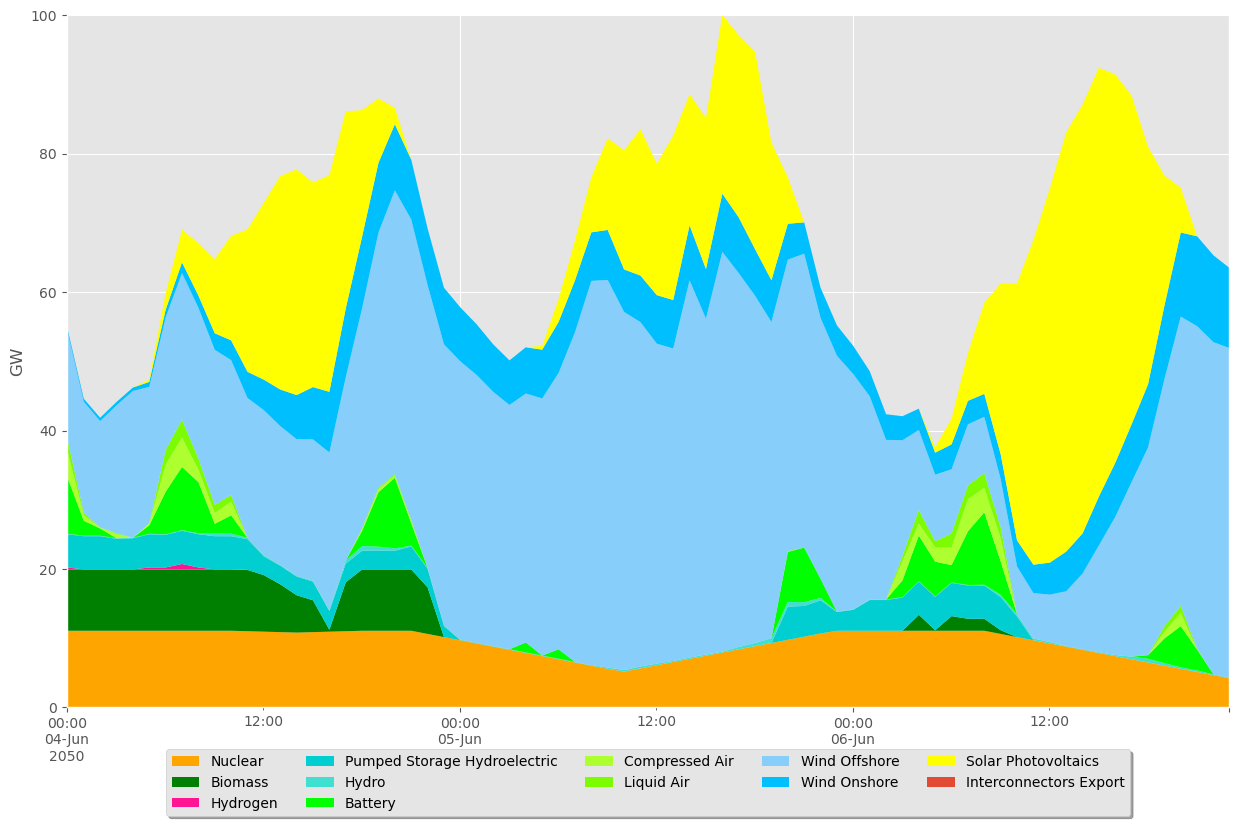

In [ ]:
cols = ["Nuclear", 'Biomass',
        'Hydrogen', 'CCS Gas', 'CCS Biomass',
        "Pumped Storage Hydroelectric", 'Hydro',
        'Battery', 'Compressed Air', 'Liquid Air',
        "Wind Offshore", 'Wind Onshore', 'Solar Photovoltaics', 
        'Unmet Load', 'Interconnectors Import'
        ]

p_by_carrier = p_by_carrier[cols]

p_by_carrier.drop(
    (p_by_carrier.max()[p_by_carrier.max() < 50.0]).index,
    axis=1, inplace=True)


colors = {"Coal": "grey",
          "Diesel/Gas oil": "black",
          "Diesel/gas Diesel/Gas oil": "black",
          'Oil': 'black',
          'Unmet Load': 'black',
          'Anaerobic Digestion': 'green',
          'Waste': 'chocolate',
          'Sewage Sludge Digestion': 'green',
          'Landfill Gas': 'green',
          'Biomass (dedicated)': 'green',
          'Biomass (co-firing)': 'green',
          'Biomass': 'green',
          'CCS Biomass': 'darkgreen',
          'Interconnectors Import': 'pink',
          'B6 import': 'pink',
          "Sour gas": "lightcoral",
          "Natural Gas": "lightcoral",
          'CCS Gas': "lightcoral",
          'Hydrogen': "deeppink",
          "Nuclear": "orange",
          'Shoreline Wave': 'aqua',
          'Tidal Barrage and Tidal Stream': 'aqua',
          'Hydro': "turquoise",
          "Large Hydro": "turquoise",
          "Small Hydro": "turquoise",
          "Pumped Storage Hydroelectric": "darkturquoise",
          'Battery': 'lime',
          'Compressed Air': 'greenyellow',
          'Liquid Air': 'lawngreen',
          "Wind Offshore": "lightskyblue",
          'Wind Onshore': 'deepskyblue',
          'Solar Photovoltaics': 'yellow'}

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
(p_by_carrier / 1e3).plot(
    kind="area", ax=ax, linewidth=0,
    color=[colors[col] for col in p_by_carrier.columns])

# stacked area plot of negative values, prepend column names with '_' such that they don't appear in the legend
(interconnector_export / 1e3).plot.area(ax=ax, stacked=True, linewidth=0.)
# rescale the y axis
ax.set_ylim([(interconnector_export / 1e3).sum(axis=1).min(), (p_by_carrier / 1e3).sum(axis=1).max()])

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

ax.set_ylabel("GW")

ax.set_xlabel("")

## Plotting network

In [ ]:
now = network.snapshots[60]

print("With the linear load flow, there is the following per unit loading:")
loading = network.links_t.p0.loc[now] / network.links.p_nom
loading.describe()

With the linear load flow, there is the following per unit loading:


count    31.000000
mean      0.232847
std       0.682789
min      -1.000000
25%      -0.239302
50%       0.286293
75%       1.000000
max       1.000000
dtype: float64

(<matplotlib.collections.PatchCollection at 0x1e18653fa60>,
 <matplotlib.collections.LineCollection at 0x1e18654a700>)

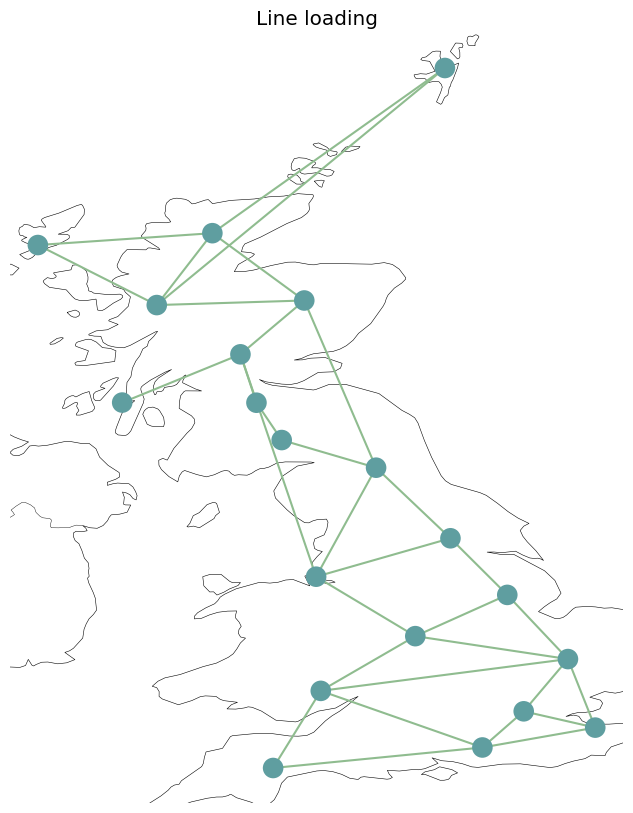

In [ ]:

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(20, 10)

network.plot(ax=ax, line_colors=abs(loading), line_cmap=plt.cm.jet, title="Line loading")

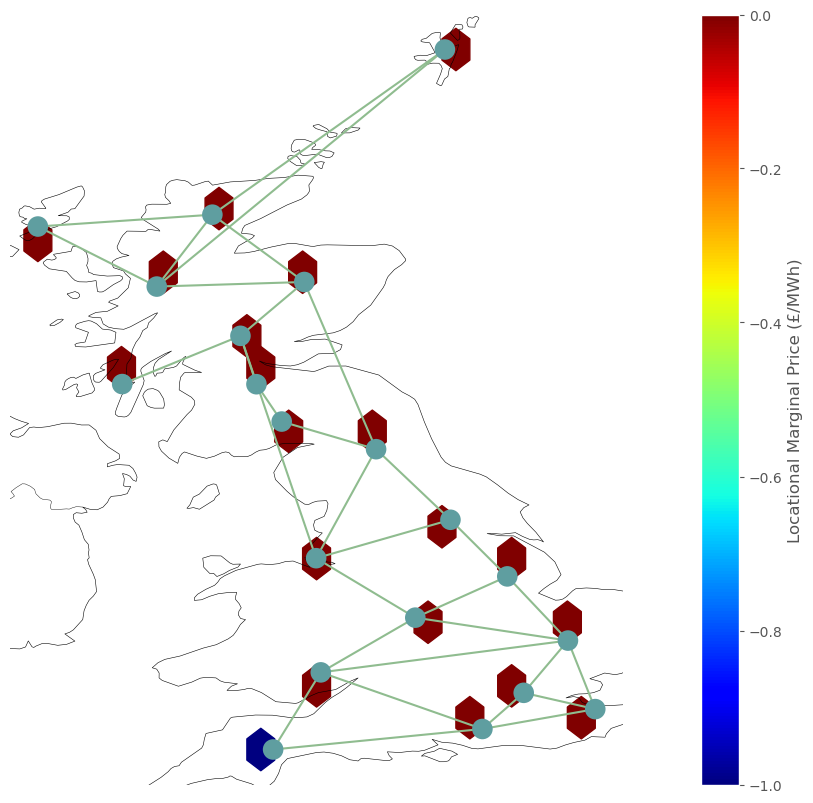

In [ ]:
now = network.snapshots[60]
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(20, 10)

network.plot(ax=ax, line_widths=pd.Series(0.5, network.links.index))
plt.hexbin(network.buses.x, network.buses.y,
           gridsize=20,
           C=network.buses_t.marginal_price.loc[now],
           cmap=plt.cm.jet)

# for some reason the colorbar only works with graphs plt.plot
# and must be attached plt.colorbar

cb = plt.colorbar()
cb.set_label('Locational Marginal Price (£/MWh)')